# Phase 1 — Question 2: Which personas have the highest/lowest churn and why?

Goal: compute and rank churn rate per persona and inspect simple explanatory indicators (answers/questions/comments per active month, reputation).
Outputs: persona summary table (CSV), correlations (CSV), churn rate chart.

In [1]:
# Imports and settings
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', 200)
print('Libraries ready.')

Libraries ready.


In [2]:
# Paths and data loading with fallback
BASE = '/Users/khaneapple/Documents/freelance/analytic_ai'
candidates_nmf = [
    os.path.join(BASE, 'data/nmf_clusters_continent_pronouns_age_20.csv'),
    os.path.join(BASE, 'nmf_clusters_continent_pronouns_age_20.csv')
]
candidates_exp = [
    os.path.join(BASE, 'data/2024_expertise_shape_final.csv'),
    os.path.join(BASE, '2024_expertise_shape_final.csv')
]

def pick_path(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    raise FileNotFoundError('No valid path found for data file: ' + str(paths))

PATH_NMF = pick_path(candidates_nmf)
PATH_EXP = pick_path(candidates_exp)

print('Loading data...')
nmf = pd.read_csv(PATH_NMF)
exp = pd.read_csv(PATH_EXP)
print(f'nmf: {nmf.shape}, exp: {exp.shape}')
print('Sample nmf columns:', [c for c in nmf.columns][:12])
print('Sample expertise columns:', [c for c in exp.columns][:12])

Loading data...
nmf: (92289, 30), exp: (556445, 8)
Sample nmf columns: ['userid', 'reputation', 'downvotes', 'upvotes', 'views', 'active_duration', 'count_posthistory', 'count_comments', 'count_badges', 'count_questions', 'count_answers', 'aboutme_length']
Sample expertise columns: ['answer_owner_id', 'expert_topics', 'expert_topic_count', 'general_topics', 'general_topic_count', 'novice_topics', 'novice_topic_count', 'expertise_shape']
nmf: (92289, 30), exp: (556445, 8)
Sample nmf columns: ['userid', 'reputation', 'downvotes', 'upvotes', 'views', 'active_duration', 'count_posthistory', 'count_comments', 'count_badges', 'count_questions', 'count_answers', 'aboutme_length']
Sample expertise columns: ['answer_owner_id', 'expert_topics', 'expert_topic_count', 'general_topics', 'general_topic_count', 'novice_topics', 'novice_topic_count', 'expertise_shape']


In [3]:
# Clean columns, compute inactive_gap and y_churn label
THRESHOLD_GAP_MONTHS = 12.0

nmf_id_candidates = [c for c in nmf.columns if c.lower() in ('userid','user_id','answer_owner_id','owner_id')]
exp_id_candidates = [c for c in exp.columns if c.lower() in ('userid','user_id','answer_owner_id','owner_id')]
if nmf_id_candidates and 'userid' not in nmf.columns:
    nmf = nmf.rename(columns={nmf_id_candidates[0]: 'userid'})
if exp_id_candidates and 'userid' not in exp.columns:
    exp = exp.rename(columns={exp_id_candidates[0]: 'userid'})
if 'userid' not in nmf.columns:
    raise KeyError('userid column is missing in nmf')

# Normalize expertise column name
exp_shape_candidates = [c for c in exp.columns if 'expertise' in c.lower() or 'shape' in c.lower()]
if exp_shape_candidates and 'expertise_shape' not in exp.columns:
    exp = exp.rename(columns={exp_shape_candidates[0]: 'expertise_shape'})

# Cast durations to numeric
for col in ['total_duration','active_duration']:
    if col in nmf.columns:
        nmf[col] = pd.to_numeric(nmf[col], errors='coerce').fillna(0)
    else:
        print(f'Warning: {col} not found in nmf.')

nmf['inactive_gap'] = (nmf.get('total_duration',0) - nmf.get('active_duration',0)).clip(lower=0)
nmf['y_churn'] = (nmf['inactive_gap'] >= THRESHOLD_GAP_MONTHS).astype(int)

# Merge expertise if available
if 'userid' in exp.columns:
    data = nmf.merge(exp[['userid','expertise_shape']].drop_duplicates('userid'), on='userid', how='left')
else:
    data = nmf.copy()

print('Prepared data. Churn rate:', f"{data['y_churn'].mean():.1%}")
print('Persona column available:', 'cluster_nmf_20' in data.columns)

Prepared data. Churn rate: 37.5%
Persona column available: True


In [4]:
# Simple explanatory features (per active month rates)
def safe_div(a, b):
    b = np.where(b==0, 1, b)
    return a / b

data['answers_rate_pm'] = safe_div(data.get('count_answers', 0), np.maximum(data.get('active_duration',0), 1))
data['questions_rate_pm'] = safe_div(data.get('count_questions', 0), np.maximum(data.get('active_duration',0), 1))
data['comments_rate_pm'] = safe_div(data.get('count_comments', 0), np.maximum(data.get('active_duration',0), 1))

print('Feature rates engineered.')

Feature rates engineered.


In [5]:
# Aggregate by persona and compute metrics
persona_col = 'cluster_nmf_20' if 'cluster_nmf_20' in data.columns else None
if persona_col is None:
    raise KeyError('Persona column (cluster_nmf_20) not found.')

agg_spec = dict(
    users=('userid','nunique'),
    churners=('y_churn','sum'),
    churn_rate=('y_churn','mean'),
    avg_inactive_gap=('inactive_gap','mean'),
    answers_rate_pm=('answers_rate_pm','mean'),
    questions_rate_pm=('questions_rate_pm','mean'),
    comments_rate_pm=('comments_rate_pm','mean'),
)
if 'reputation' in data.columns:
    agg_spec['reputation'] = ('reputation','mean')

persona = data.groupby(persona_col).agg(**agg_spec).reset_index()
persona = persona.sort_values('churn_rate', ascending=False)
print('Top personas by churn rate:')
display(persona.head(10))
print('Bottom personas by churn rate:')
display(persona.tail(10))

Top personas by churn rate:


,cluster_nmf_20,users,churners,churn_rate,avg_inactive_gap,answers_rate_pm,questions_rate_pm,comments_rate_pm,reputation
18,18,1080,625,0.578704,31.072222,0.119382,0.059673,0.131736,226.317593
9,9,5254,3005,0.571945,31.420822,0.269505,0.110892,0.480894,1165.761705
19,19,1466,837,0.570941,29.149386,0.318208,0.105665,0.562184,1521.317872
16,16,3535,1624,0.459406,23.605941,0.386810,0.121893,0.965500,3030.802829
11,11,2756,1230,0.446299,24.567126,0.686715,0.157001,1.439788,5879.561684
1,1,13515,5971,0.441805,21.314095,0.451214,0.156574,0.848968,1560.965890
4,4,9739,3741,0.384126,18.676353,0.405960,0.143696,0.888217,1950.612897
5,5,18131,6830,0.376703,18.875352,0.453880,0.132816,0.939570,2271.645800
2,2,2612,968,0.370597,18.025268,1.006793,0.203587,2.093256,6567.506508
7,7,1472,545,0.370245,16.977582,0.919012,0.223164,1.787876,4390.040761


Bottom personas by churn rate:


,cluster_nmf_20,users,churners,churn_rate,avg_inactive_gap,answers_rate_pm,questions_rate_pm,comments_rate_pm,reputation
15,15,11133,3796,0.340968,16.655169,0.871516,0.196141,2.009343,7244.584568
12,12,1331,397,0.298272,14.201352,1.835417,0.285326,3.755400,9541.525920
10,10,1236,360,0.291262,13.716019,1.713660,0.261276,4.352460,19081.520227
6,6,3057,890,0.291135,13.734053,1.072736,0.197223,2.596810,7914.291135
13,13,781,214,0.274008,12.829706,2.313035,0.262306,5.683630,15046.439181
3,3,3828,949,0.247910,12.264107,2.899263,0.280958,6.678311,25675.392111
0,0,5047,1245,0.246681,11.506439,0.985969,0.194872,2.214322,8637.402021
8,8,2780,653,0.234892,10.897842,1.733467,0.218284,4.306451,12635.357914
17,17,2984,599,0.200737,9.000670,2.673979,0.246510,5.850703,23603.010389
14,14,552,103,0.186594,7.199275,3.368861,0.251933,8.177666,33961.952899


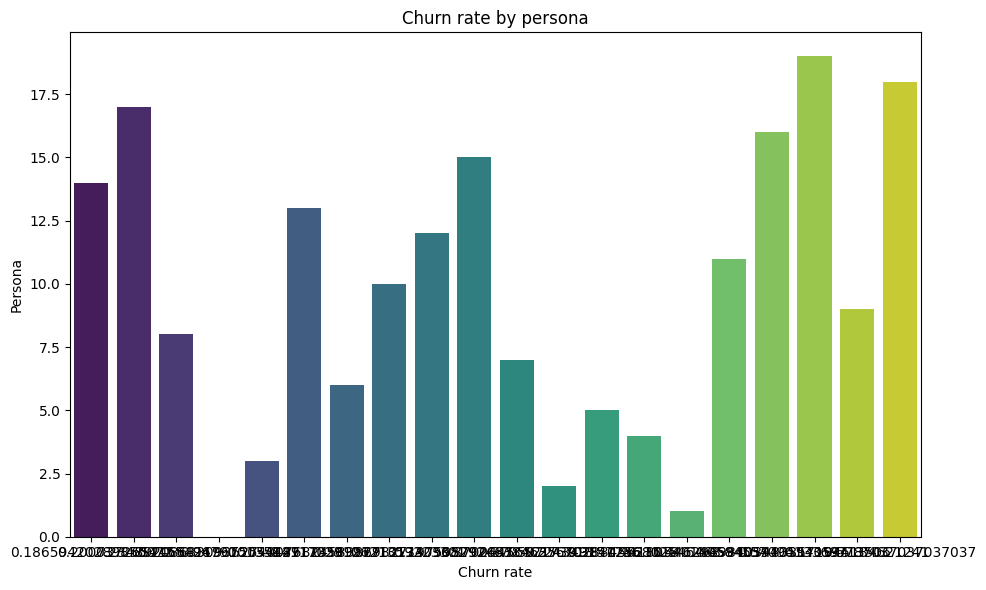

In [6]:
# Churn rate chart
plt.figure(figsize=(10,6))
sns.barplot(data=persona, x='churn_rate', y=persona_col, palette='viridis')
plt.xlabel('Churn rate')
plt.ylabel('Persona')
plt.title('Churn rate by persona')
plt.tight_layout()
plt.show()

In [7]:
# Correlation of churn_rate with explanatory features
corr_features = [c for c in ['answers_rate_pm','questions_rate_pm','comments_rate_pm','avg_inactive_gap'] if c in persona.columns]
if 'reputation' in persona.columns: corr_features.append('reputation')
corr_df = persona[['churn_rate'] + corr_features].corr().loc[corr_features, 'churn_rate'].sort_values(ascending=False).to_frame('corr_with_churn')
print('Correlations with churn_rate:')
print(corr_df)

Correlations with churn_rate:
                   corr_with_churn
avg_inactive_gap          0.994004
reputation               -0.786138
answers_rate_pm          -0.826914
comments_rate_pm         -0.829587
questions_rate_pm        -0.862351


In [8]:
# Save outputs
out_dir = os.path.join(BASE, 'phase1', 'question_2_persona_churn', 'outputs')
os.makedirs(out_dir, exist_ok=True)
persona_csv = os.path.join(out_dir, 'phase1_q2_persona_churn_summary.csv')
persona.to_csv(persona_csv, index=False)
print('Saved:', persona_csv)
corr_csv = os.path.join(out_dir, 'phase1_q2_persona_churn_correlations.csv')
corr_df.to_csv(corr_csv)
print('Saved:', corr_csv)

Saved: /Users/khaneapple/Documents/freelance/analytic_ai/phase1/question_2_persona_churn/outputs/phase1_q2_persona_churn_summary.csv
Saved: /Users/khaneapple/Documents/freelance/analytic_ai/phase1/question_2_persona_churn/outputs/phase1_q2_persona_churn_correlations.csv


## Quick notes
- The persona table is sorted by churn rate; the top rows are higher risk.
- The per-active-month rate features help explain persona differences.
- In the report, highlight the top-3 and bottom-3 personas by churn.

## Conclusion
- Overall churn rate is about 37.5%.
- Highest-churn personas: 18 (~57.9%), 9 (~57.2%), 19 (~57.1%). These groups have longer inactive gaps and comparatively lower engagement per active month.
- Lowest-churn personas: 14 (~18.7%), 17 (~20.1%), 8 (~23.5%). These groups show much higher answers/questions/comments per active month and higher reputation.
- Drivers (persona level): larger average inactive_gap correlates positively with churn; higher activity rates and reputation correlate negatively. This suggests activation and engagement programs focused on high-churn personas (e.g., nudges to answer/ask, reputation-building paths) are likely to reduce churn.
- Notes: threshold for churn = 12 months of inactivity; persona label = cluster_nmf_20.
